# 1. Time series analysis

**We are using Prophet and ARIMA to analyze the number of views for a Wikipedia [page](https://en.wikipedia.org/wiki/Machine_learning) on Machine Learning.**

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater
init_notebook_mode(connected=True)

5.9.0


In [2]:
def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

## 1.1. Data preparation

In [3]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [4]:
df = pd.read_csv(DATA_PATH + "wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [5]:
df.shape

(383, 7)

## 1.2. Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [6]:
df.date = pd.to_datetime(df.date)

In [7]:
plotly_df(df.set_index("date")[["count"]])

In [8]:
from prophet import Prophet

In [9]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


**We will predict the number of views of the wiki page on January 20? Round it up to the nearest integer.**

In [10]:
train_df = df[:-predictions].copy()

In [11]:
m = Prophet()
m.fit(train_df);

19:48:16 - cmdstanpy - INFO - Chain [1] start processing
19:48:16 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [13]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2974.868062,1716.573852,2509.560638,2956.214839,2994.271225,-861.750203,-861.750203,-861.750203,-861.750203,-861.750203,-861.750203,0.0,0.0,0.0,2113.117858
379,2016-01-17,2980.203432,1869.696673,2688.687212,2960.659655,3000.584576,-720.764621,-720.764621,-720.764621,-720.764621,-720.764621,-720.764621,0.0,0.0,0.0,2259.438811
380,2016-01-18,2985.538803,2839.854033,3674.034618,2964.154670,3007.028441,281.423875,281.423875,281.423875,281.423875,281.423875,281.423875,0.0,0.0,0.0,3266.962677
381,2016-01-19,2990.874173,3131.991919,3941.923353,2968.481628,3014.145418,541.444852,541.444852,541.444852,541.444852,541.444852,541.444852,0.0,0.0,0.0,3532.319025
382,2016-01-20,2996.209544,3031.087071,3825.762481,2972.896498,3020.696153,425.537704,425.537704,425.537704,425.537704,425.537704,425.537704,0.0,0.0,0.0,3421.747248


The number of wiki page views on January 20 will be approximately 3421.

**Calculate the MAPE and MAE**

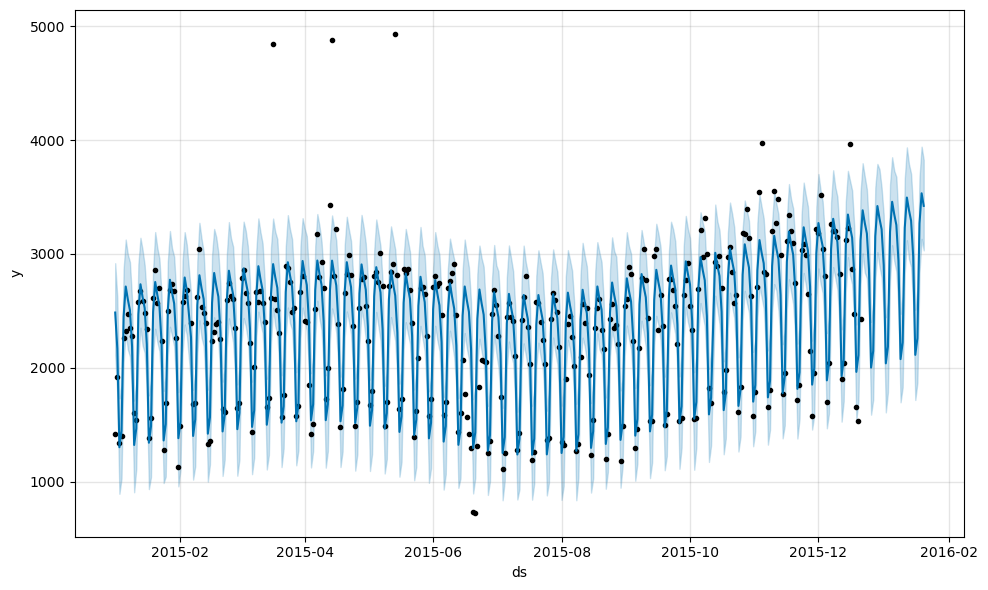

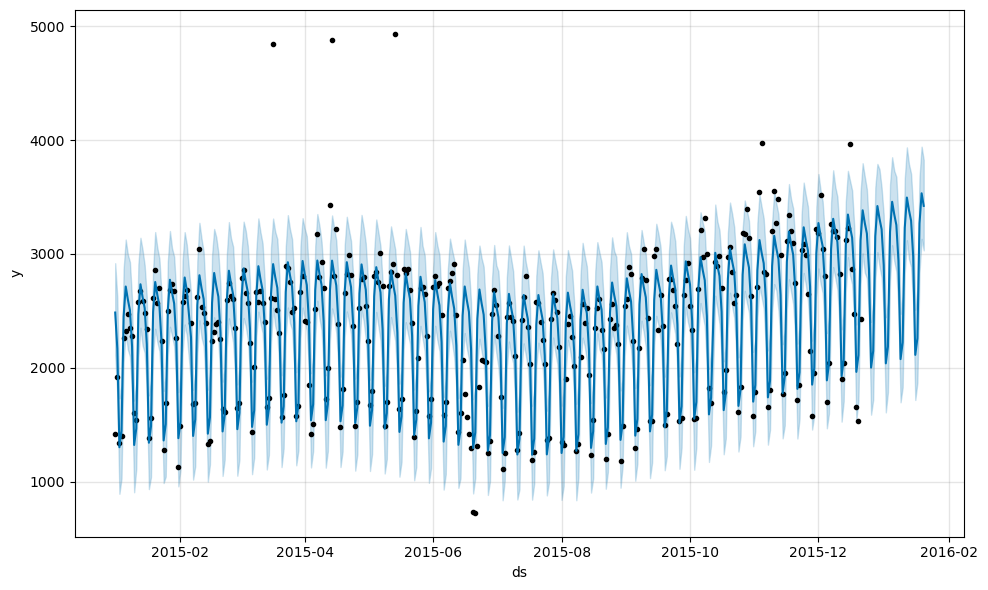

In [14]:
m.plot(forecast)

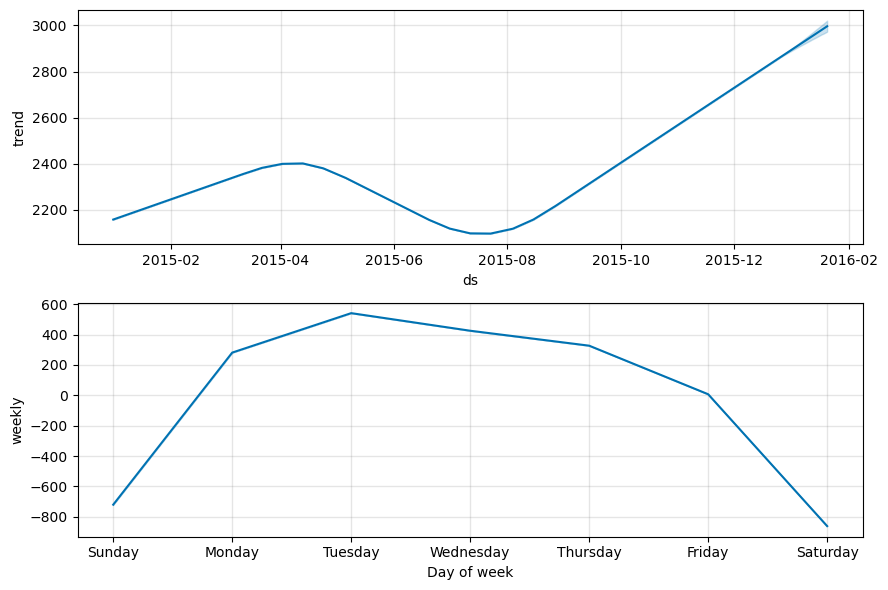

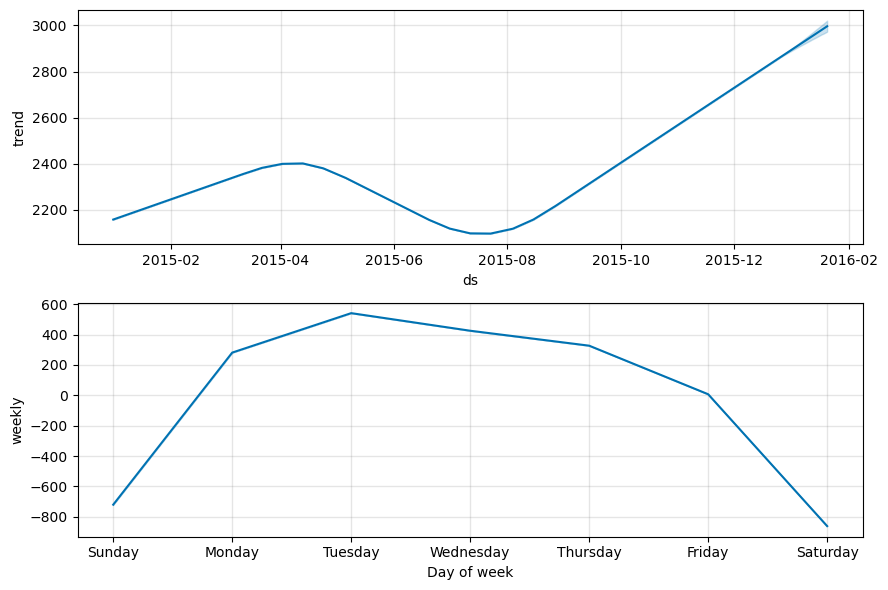

In [15]:
m.plot_components(forecast)

In [16]:
cmp_df = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
    df.set_index("ds")
)

In [17]:
cmp_df["e"] = cmp_df["y"] - cmp_df["yhat"]
cmp_df["p"] = 100 * cmp_df["e"] / cmp_df["y"]
print("MAPE = ", round(np.mean(abs(cmp_df[-predictions:]["p"])), 2))
print("MAE = ", round(np.mean(abs(cmp_df[-predictions:]["e"])), 2))

MAPE =  34.34
MAE =  596.46


Estimate the quality of the prediction with the last 30 points.

## 1.3. Predicting with ARIMA

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

plt.rcParams["figure.figsize"] = (15, 10)

**Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

Dickey-Fuller test: p=0.107392


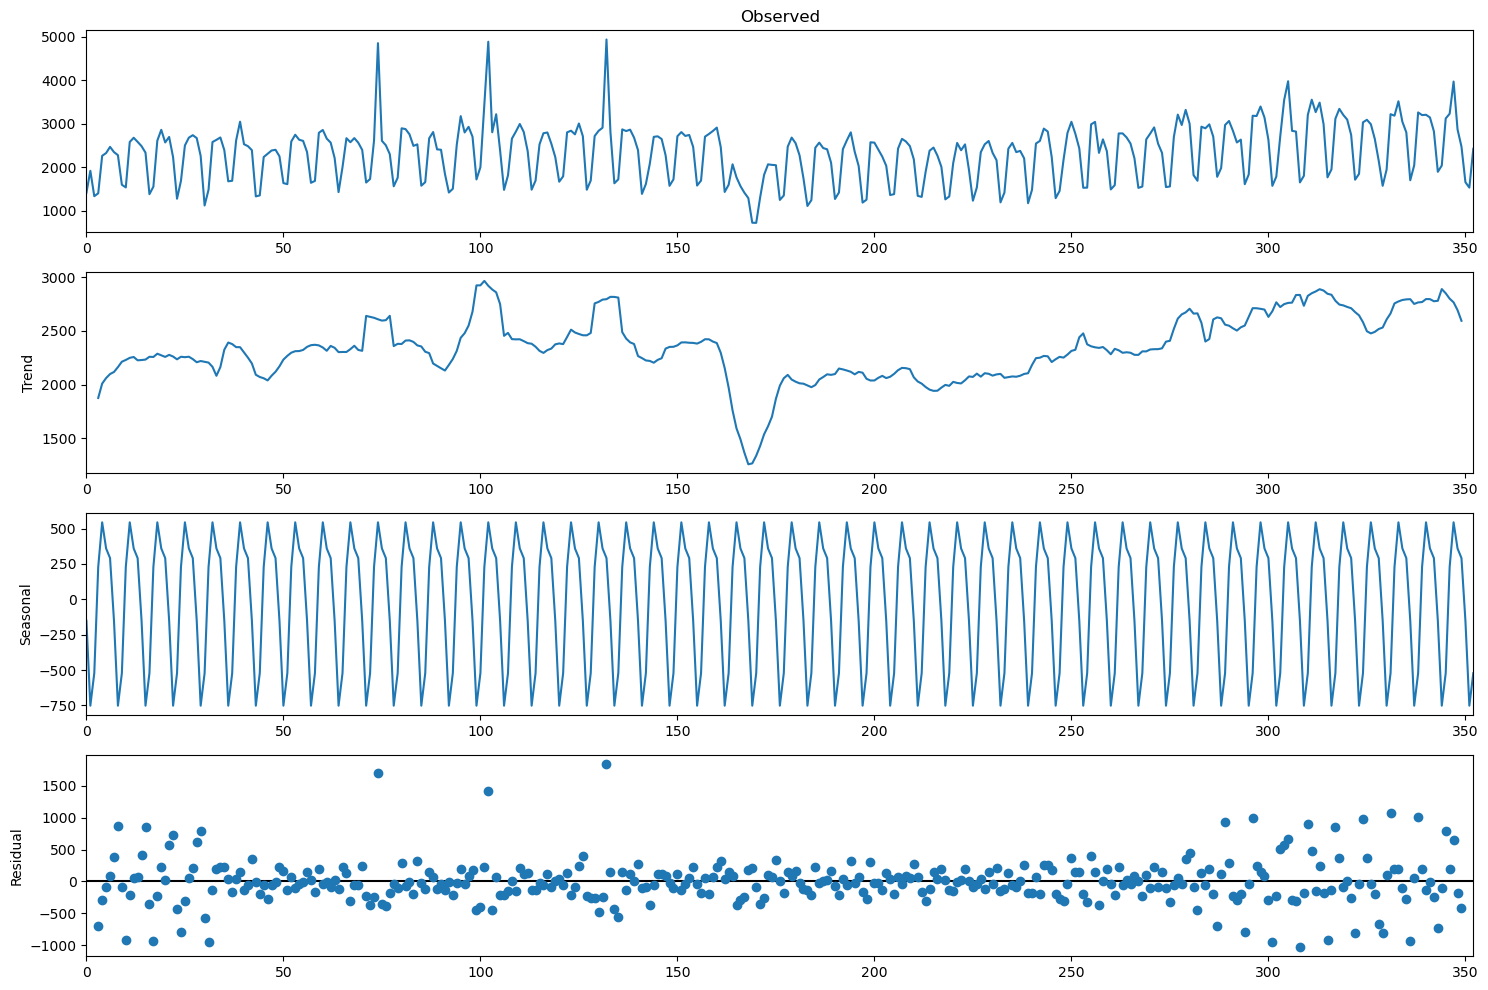

In [19]:
sm.tsa.seasonal_decompose(train_df["y"].values, period=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df["y"])[1])

But the seasonally differentiated series will already be stationary.

In [20]:
train_df.set_index("ds", inplace=True)

Dickey-Fuller test: p=0.000000


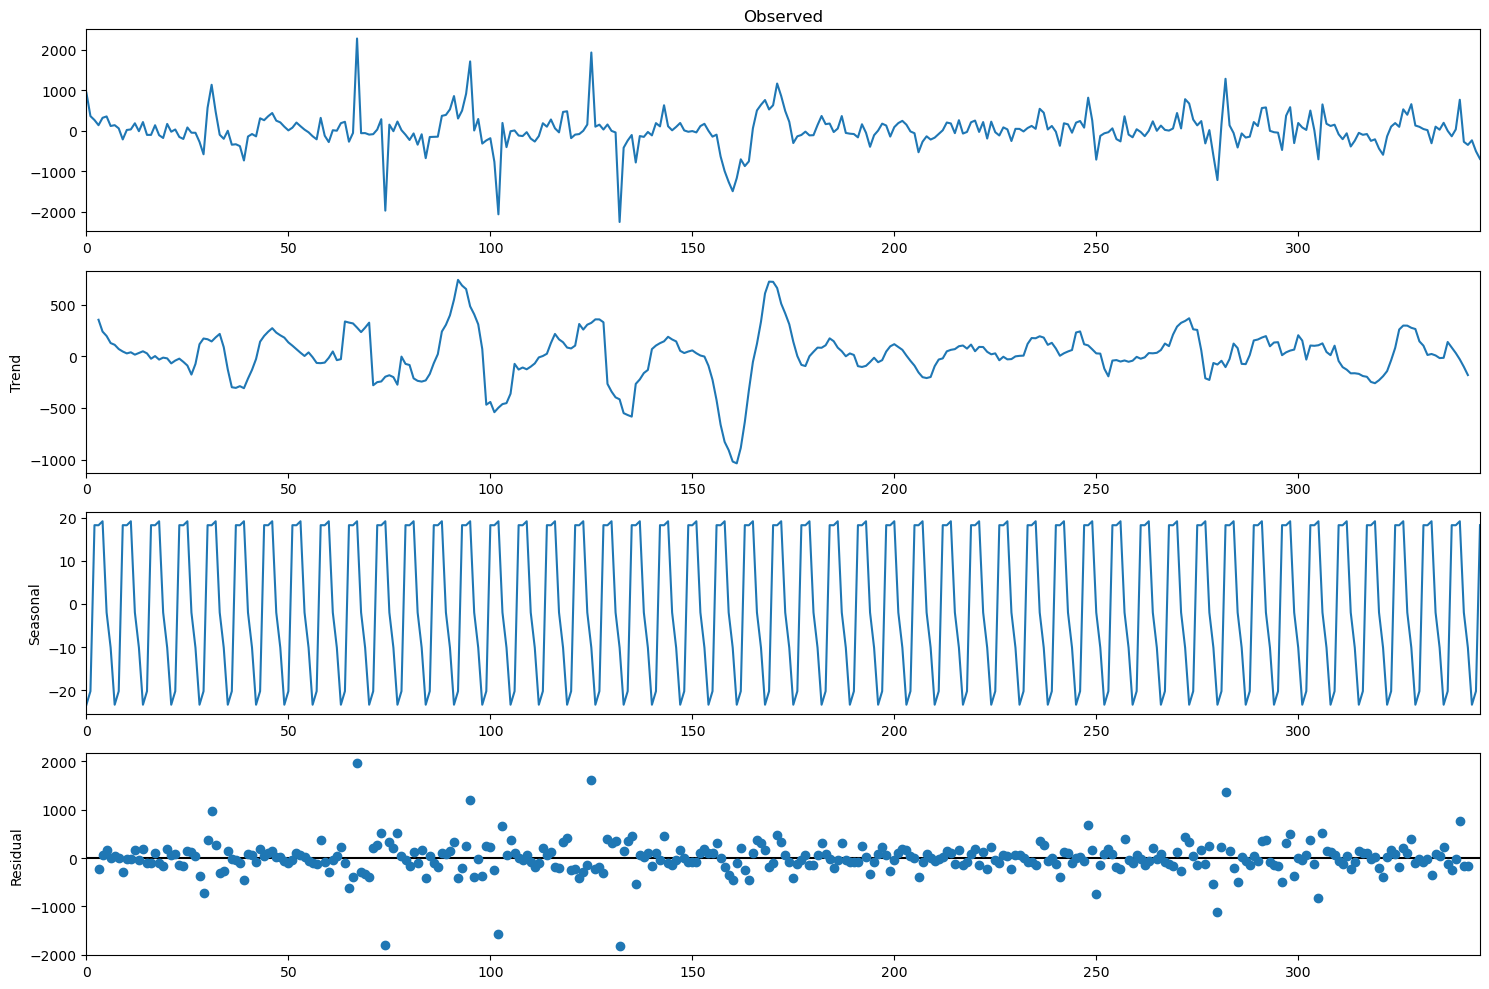

In [21]:
train_df["y_diff"] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, period=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

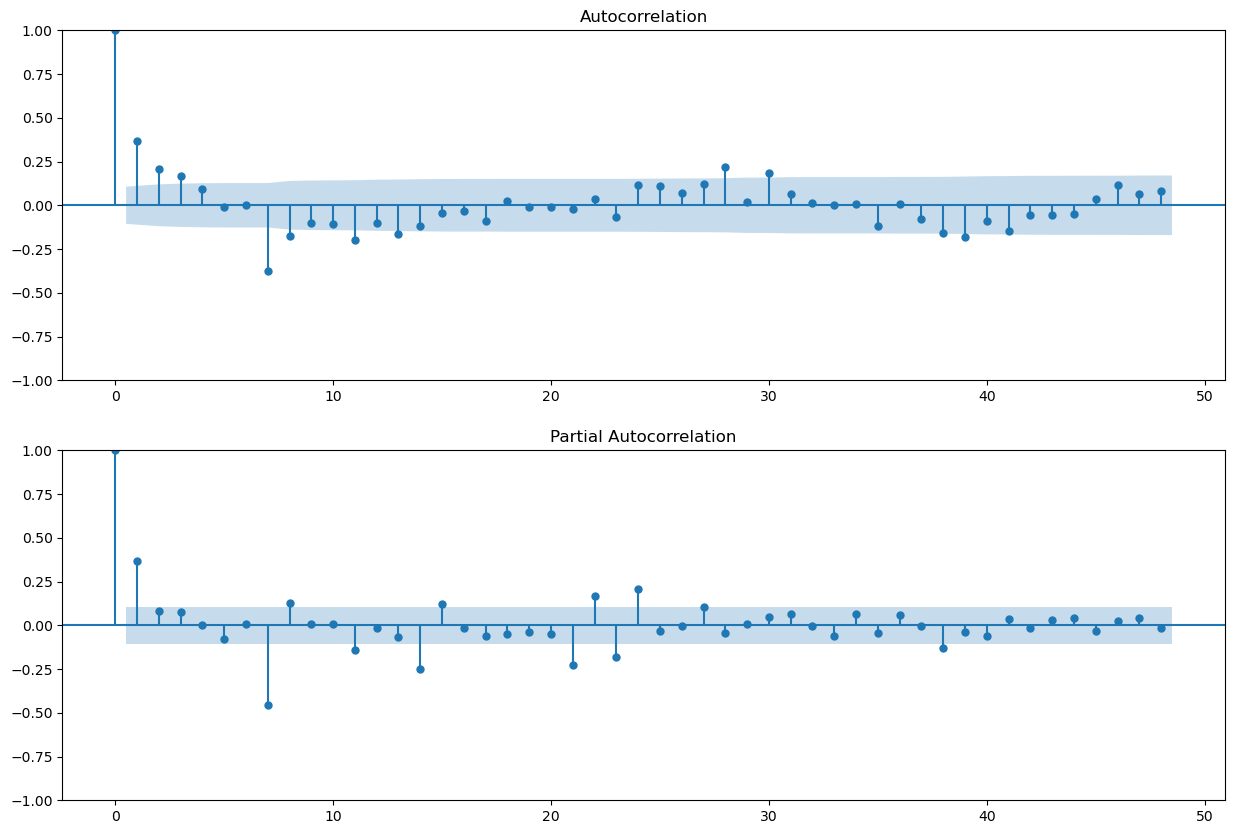

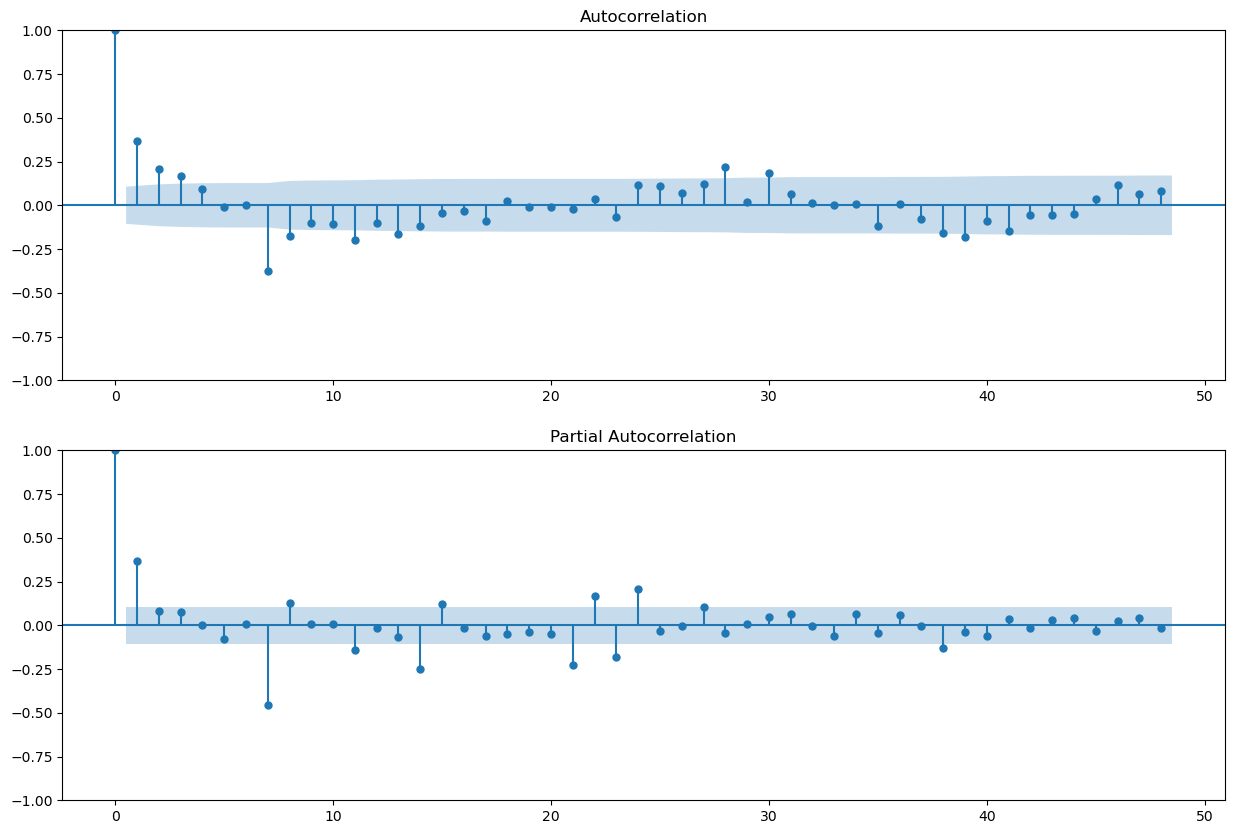

In [22]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

Initial values:
* Q = 1
* q = 3
* P = 3
* p = 1

In [23]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [24]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [25]:
%%time
import warnings

from tqdm.notebook import tqdm

results1 = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
        ).fit(disp=-1)

    except (ValueError, np.linalg.LinAlgError):
        continue

    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

  0%|          | 0/384 [00:00<?, ?it/s]

CPU times: total: 12min 24s
Wall time: 3min 34s


In [26]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ["parameters", "aic"]
print(result_table1.sort_values(by="aic", ascending=True).head())

             parameters          aic
37   (0, 0, 1, 2, 0, 1)    10.000000
43   (0, 0, 1, 3, 0, 1)    12.000000
331  (1, 1, 1, 3, 0, 1)    14.000000
133  (0, 1, 1, 2, 0, 1)    31.699986
167  (0, 1, 2, 3, 2, 1)  4961.632628


In [27]:
result_table1[
    result_table1["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
].sort_values(by="aic")

,parameters,aic
357,"(1, 1, 2, 3, 2, 1)",4988.989449
355,"(1, 1, 2, 3, 1, 1)",5019.555903
260,"(1, 0, 2, 3, 1, 0)",5022.312525
258,"(1, 0, 2, 3, 0, 0)",5183.741298


Now do the same, but for the series with Box-Cox transformation.

In [28]:
import scipy.stats

train_df["y_box"], lmbda = scipy.stats.boxcox(train_df["y"])
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [29]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y_box"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
            enforce_stationary=False,  
            enforce_invertibility=False  
        ).fit(disp=-1)

    except (ValueError, np.linalg.LinAlgError):
        continue

    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])

warnings.filterwarnings("default")

  0%|          | 0/384 [00:00<?, ?it/s]

In [30]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ["parameters", "aic"]
print(result_table2.sort_values(by="aic", ascending=True).head())

             parameters          aic
78   (0, 0, 3, 1, 0, 1)    12.000000
83   (0, 0, 3, 2, 0, 0)    12.000000
60   (0, 0, 2, 2, 0, 1)    12.000000
262  (1, 0, 2, 3, 2, 1)  3528.604777
286  (1, 0, 3, 3, 2, 1)  3529.820329


In [31]:
result_table2[
    result_table2["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
].sort_values(by="aic")

,parameters,aic
259,"(1, 0, 2, 3, 1, 0)",3556.880030
356,"(1, 1, 2, 3, 1, 1)",3557.923218
358,"(1, 1, 2, 3, 2, 1)",3559.076529
257,"(1, 0, 2, 3, 0, 0)",3674.914345


**Next, we turn to the construction of the SARIMAX model**

**What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

In [32]:
best_model = sm.tsa.statespace.SARIMAX(
    train_df["y_box"],
    order=(1, 0, 2),
    seasonal_order=(3, 2, 1, 7),
    enforce_stationary=False,  
    enforce_invertibility=False  
).fit(disp=-1)

C:\Users\kosty\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\kosty\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [33]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, [1], 7)   Log Likelihood               -1756.302
Date:                             Fri, 14 Jul 2023   AIC                           3528.605
Time:                                     19:55:18   BIC                           3559.213
Sample:                                          0   HQIC                          3540.802
                                             - 353                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7916      0.132      6.003      0.000       0.533       1.050
ma.L1         -0.2971      

Student's test: p=0.125524
Dickey-Fuller test: p=0.000000


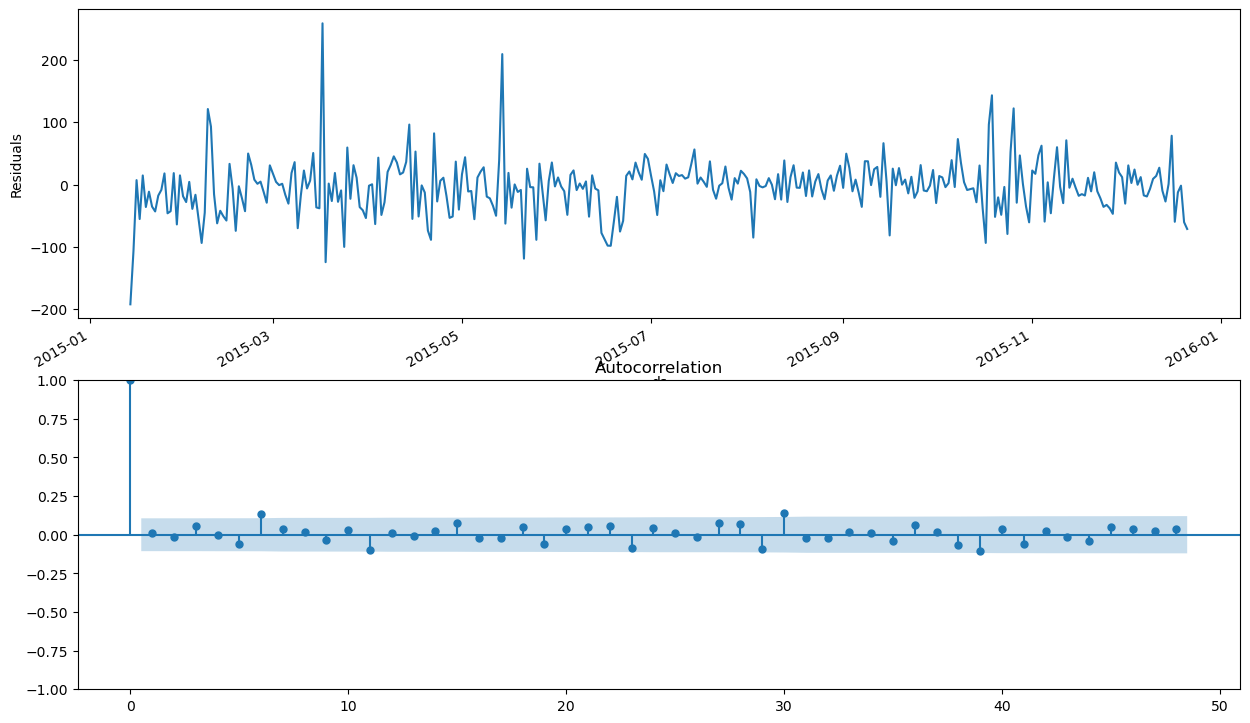

In [34]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [35]:
def invboxcox(y, lmbda):
    # reverse Box Cox transformation
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

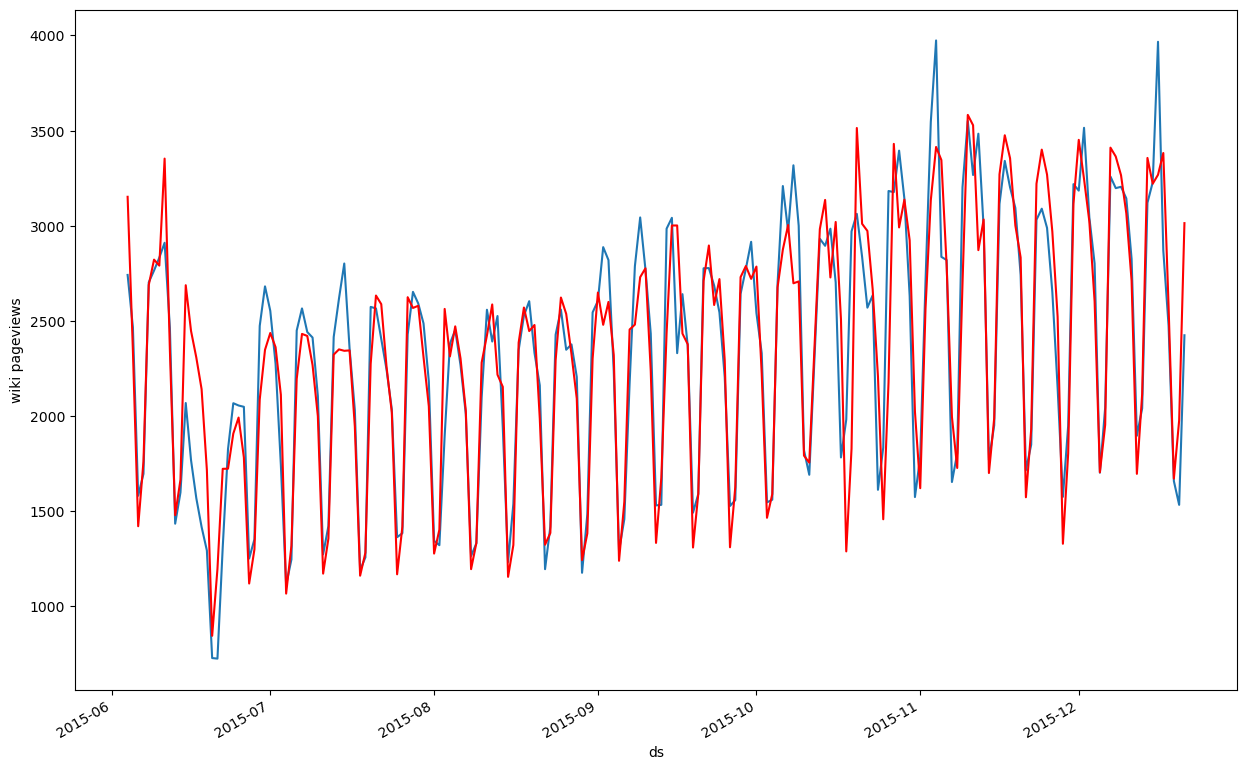

In [36]:
train_df["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)

train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color="r")
plt.ylabel("wiki pageviews");